In [1]:
import random

import numpy as np
from torch.utils.data import DataLoader
import torch
from src.model.model import MusicTransformer
from pathlib import Path

from src.utils.data.guitar_dataset import GuitarDataset
from src.utils.data.random_guitar_seq_dataset import RandomGuitarSeqDataset
from src.utils.hyperparameters import BATCH_SIZE, BLOCK_SIZE, EMBEDDING_DIM, N_LAYER, N_HEAD, DROPOUT, VOCAB_SIZE, \
    LEARNING_RATE

In [2]:
data_root = Path("../data/")
midi_folder = data_root / "midi/"
augmented_folder = data_root / "augmented/"
tokenized_folder = data_root / "tokenized/"
splits_folder = data_root / "splits/"
train_tok_folder = tokenized_folder / "train-aug/"
val_tok_folder = tokenized_folder / "val/"
train_midi_folder = data_root / "train-midi/"
val_midi_folder = data_root / "val-midi/"

In [3]:
# hyper-parameters
batch_size = BATCH_SIZE

block_size = BLOCK_SIZE
n_embd = EMBEDDING_DIM
vocab_size = VOCAB_SIZE
n_layer = N_LAYER
n_head = N_HEAD
dropout = DROPOUT

learning_rate = LEARNING_RATE
training_split = 0.8

In [4]:
# setting the device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
# AMP setup, works only on CUDA
torch.backends.cuda.matmul.allow_tf32 = True
torch.set_float32_matmul_precision("high")

use_amp = (device.type == "cuda")
if use_amp and hasattr(torch.cuda,"is_bf16_supported") and torch.cuda.is_bf16_supported():
    amp_dtype = torch.bfloat16
else:
    amp_dtype = torch.float16

/home/piffs/dev/miniconda3/envs/music-llm/lib/python3.12/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [6]:
print(hasattr(torch.cuda,"is_bf16_supported"))
print(torch.cuda.is_bf16_supported())
print(use_amp)
print(device.type == "cuda")
device

True
True
True
True


device(type='cuda')

In [7]:
print("Using device", device)
print("amp dtype", amp_dtype)
print("Torch version", torch.__version__)

Using device cuda
amp dtype torch.bfloat16
Torch version 2.9.0+cu128


In [8]:
# prepare datasets
train_files = sorted(train_tok_folder.glob("*.json"))
val_files = sorted(val_tok_folder.glob("*.json"))
random.shuffle(train_files)

# train_ds = GuitarDataset(block_size=block_size, stride=block_size // 2, file_list=train_files)
# val_ds = GuitarDataset(block_size=block_size, stride=block_size // 2, file_list=val_files)
train_ds = RandomGuitarSeqDataset(block_size=block_size, epoch_len=2000, file_list=train_files)
val_ds = RandomGuitarSeqDataset(block_size=block_size,  epoch_len=400, file_list=val_files)

In [9]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True, drop_last=True)

In [10]:
print("Training tokens count", train_dl.dataset.total_tokens)
print("Validation tokens count", val_dl.dataset.total_tokens)

Training tokens count 5610867
Validation tokens count 643957


In [11]:
model = MusicTransformer(
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    block_size=block_size,
    dropout=dropout
).to(device)

In [12]:
# using AdamW optimisation
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1)

In [13]:
print("Parameter count: ", sum([p.numel() for p in model.parameters()]))
print("Training on ", device)
print("Using amp?", use_amp, amp_dtype)

Parameter count:  14361240
Training on  cuda
Using amp? True torch.bfloat16


In [14]:
# from src.model.model import Head
# import numpy as np
# x_test, y_test = train_ds.__getitem__(56)
# x_test, y_test = x_test.view(1,-1).to(device), y_test.view(1,-1).to(device)
#
print(-np.log(1/8000))
device
#
# logits, loss = model(x_test, y_test)
# loss

8.987196820661973


device(type='cuda')

In [15]:
scaler = torch.amp.GradScaler('cuda', enabled=(use_amp and amp_dtype == torch.float16))

In [17]:
epochs = 20
V = vocab_size
lnV = np.log(V)

for epoch in range(epochs):
    # ---- train -----
    model.train()
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        # using torch.autocast here with device_type to avoid backend-specific contexts
        with torch.amp.autocast('cuda', dtype=amp_dtype, enabled=torch.cuda.is_available()):
            logits, loss = model(x, y)

        if use_amp and amp_dtype == torch.float16:
            # FP16 path: scale, unscale before clipping, then step
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            # BF16 path
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

    # ----- validate -----
    model.eval()
    val_loss, total_tokens = 0.0, 0
    with torch.no_grad():
        # also using AMP in eval to cut memory/latency
        with torch.amp.autocast('cuda',dtype=amp_dtype, enabled=use_amp):
            for x, y in val_dl:
                x, y = x.to(device), y.to(device)
                _, l = model(x, y) # loss here is already mean loss per token for this batch
                # as we have already reshaped logits in forward when computing loss against targets
                num_tokens = y.numel()
                val_loss += l.item() * num_tokens
                total_tokens += num_tokens

    avg_loss = val_loss / total_tokens
    ppl = np.exp(avg_loss)
    bpc = avg_loss / np.log(2)
    improv_ratio = V / ppl
    delta_nats = lnV - avg_loss

    print(
        f"epoch {epoch:03d} "
        f"train {loss.item():.4f} "
        f"val_loss {avg_loss:.4f}  ppl {ppl:.0f}  "
        f"bpc {bpc:.3f}  Δnats {delta_nats:.3f}  x-better {improv_ratio:.2f}x  (lnV {lnV:.3f})"
    )

epoch 000 train 7.1737 val_loss 7.1903  ppl 1327  bpc 10.373  Δnats 0.816  x-better 2.26x  (lnV 8.006)
epoch 001 train 6.9375 val_loss 6.9598  ppl 1053  bpc 10.041  Δnats 1.047  x-better 2.85x  (lnV 8.006)
epoch 002 train 5.9126 val_loss 6.1621  ppl 474  bpc 8.890  Δnats 1.844  x-better 6.32x  (lnV 8.006)
epoch 003 train 5.4810 val_loss 5.6278  ppl 278  bpc 8.119  Δnats 2.379  x-better 10.79x  (lnV 8.006)
epoch 004 train 5.1717 val_loss 5.3011  ppl 201  bpc 7.648  Δnats 2.705  x-better 14.96x  (lnV 8.006)
epoch 005 train 4.7211 val_loss 5.0709  ppl 159  bpc 7.316  Δnats 2.935  x-better 18.83x  (lnV 8.006)
epoch 006 train 4.6623 val_loss 4.9030  ppl 135  bpc 7.074  Δnats 3.103  x-better 22.27x  (lnV 8.006)
epoch 007 train 4.5894 val_loss 4.7863  ppl 120  bpc 6.905  Δnats 3.220  x-better 25.03x  (lnV 8.006)
epoch 008 train 4.3063 val_loss 4.6267  ppl 102  bpc 6.675  Δnats 3.380  x-better 29.36x  (lnV 8.006)
epoch 009 train 4.1457 val_loss 4.5350  ppl 93  bpc 6.543  Δnats 3.471  x-better 

ModuleList(
  (0-3): 4 x RelativeHead(
    (query): Linear(in_features=384, out_features=96, bias=False)
    (key): Linear(in_features=384, out_features=96, bias=False)
    (value): Linear(in_features=384, out_features=96, bias=False)
    (rel_bias): Embedding(1023, 1)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)


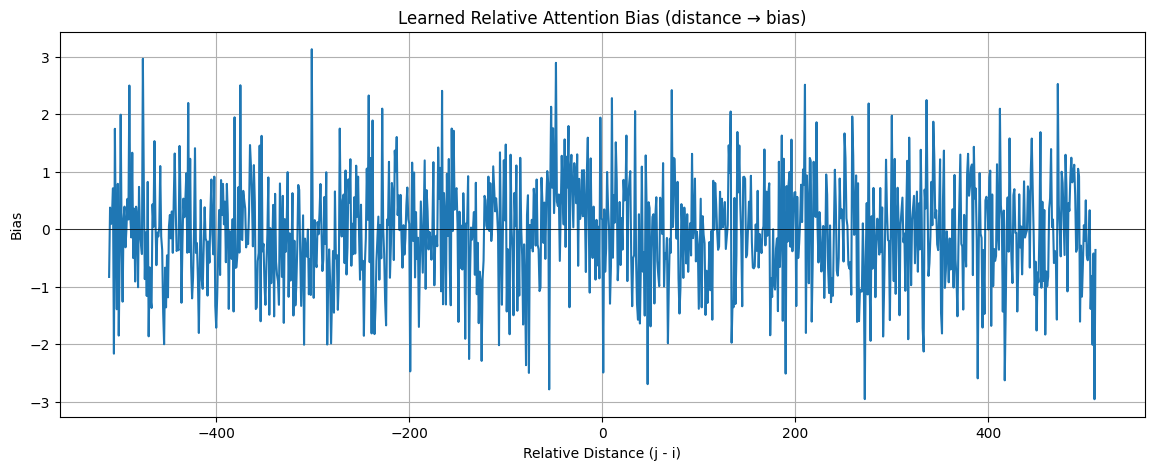

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Extract bias weights from one head (example)
heads = model.blocks[0].mmha.heads
print(heads)
rel_bias = heads[0].rel_bias.weight
bias = rel_bias.detach().cpu().squeeze(-1).numpy()

T = model.block_size
distances = np.arange(-T+1, T)

plt.figure(figsize=(14, 5))
plt.plot(distances, bias)
plt.axhline(0, color='black', linewidth=0.5)
plt.title("Learned Relative Attention Bias (distance → bias)")
plt.xlabel("Relative Distance (j - i)")
plt.ylabel("Bias")
plt.grid(True)
plt.show()


In [17]:
item = 311
x, y = val_dl.dataset.__getitem__(item)
temp = x[:500]
out = model.generate(temp.view(1, -1).to(device), max_new_tokens=2500).cpu()
out

tensor([[809, 183, 560,  ..., 534,  49, 545]])

In [18]:
from miditok import REMI, TokenizerConfig

tokenizer = REMI(params=Path("../data/tokenized/config/tokenizer.json"))
print("Is trained", tokenizer.is_trained)
out_midi = tokenizer.decode(out[0])
temp_midi = tokenizer.decode(temp)

Is trained True


/home/piffs/dev/miniconda3/envs/music-llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/piffs/dev/miniconda3/envs/music-llm/lib/python3.12/site-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


In [19]:
out_midi.dump_midi(data_root / "output" / f"{item}_test_gen_2.mid")
temp_midi.dump_midi(data_root / "output" / f"{item}_input_input_2.mid")